In [3]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [11]:
from google.cloud import bigquery

client = bigquery.Client(project='bads-7105-308315')

df = client.query('''
SELECT * FROM `bads-7105-308315.supermarket.transaction`
WHERE CUST_CODE IS NOT NULL 
''').to_dataframe()

df

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200732,20071005,6,17,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000583261,UM,YF,994107800547472,L,MM,Top Up,Grocery,STORE00001,LS,E02
1,200733,20071010,4,20,3,6.75,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000537317,MM,OF,994107900512001,L,MM,Full Shop,Fresh,STORE00001,LS,E02
2,200741,20071209,1,11,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000472158,MM,YF,994108700468327,L,MM,Full Shop,Grocery,STORE00001,LS,E02
3,200731,20070929,7,17,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000099658,LA,OF,994107700237811,L,LA,Full Shop,Mixed,STORE00001,LS,E02
4,200746,20080108,3,15,1,2.25,PRD0900001,CL00072,DEP00021,G00007,D00002,CUST0000556927,MM,None,994109200504187,L,MM,Top Up,Fresh,STORE00001,LS,E02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802887,200633,20061009,2,12,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000689580,LA,OT,994102700591584,L,LA,Full Shop,Mixed,STORE00002,LS,W01
802888,200634,20061022,1,16,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000910590,LA,OA,994102800730797,L,LA,Top Up,Grocery,STORE00002,LS,W01
802889,200618,20060701,7,12,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000956717,LA,OA,994101200777910,L,LA,Top Up,Fresh,STORE00002,LS,W01
802890,200617,20060622,5,18,3,3.96,PRD0904997,CL00074,DEP00021,G00007,D00002,CUST0000544241,LA,YA,994101100506174,L,LA,Top Up,Fresh,STORE00002,LS,W01


In [76]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale, StandardScaler
from sklearn.ensemble import RandomForestClassifier 

In [35]:
campaign_date = dt.datetime(2021,3,17)
df_transactions = df.copy()
df_transactions['SHOP_DATE'] = pd.to_datetime(df_transactions['SHOP_DATE'], format='%Y%m%d')
df_transactions['AGE'] = (campaign_date - df_transactions['SHOP_DATE']).dt.days
df_transactions = df_transactions.sort_values(['CUST_CODE','SHOP_DATE'])
df_transactions.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,PROD_CODE_40,CUST_CODE,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION,AGE
188786,200645,2007-01-06,7,13,1,2.44,PRD0901946,CL00079,DEP00022,G00007,D00002,CUST0000000181,MM,None,994103900142002,S,MM,Small Shop,Fresh,STORE00001,LS,E02,5184
578804,200607,2006-04-16,1,18,1,0.40,PRD0901383,CL00044,DEP00011,G00004,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449
674063,200607,2006-04-16,1,18,1,0.72,PRD0903052,CL00031,DEP00008,G00004,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449
743565,200607,2006-04-16,1,18,1,2.86,PRD0903953,CL00076,DEP00022,G00007,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449
770706,200607,2006-04-16,1,18,1,1.79,PRD0904393,CL00087,DEP00025,G00008,D00002,CUST0000000369,MM,OA,994100100152797,M,UM,Small Shop,Fresh,STORE00002,LS,W01,5449


# **Feature Engineering**

In [66]:
#Customer Movement
df_movement = df_transactions[['CUST_CODE','SHOP_DATE']].copy()
df_movement = df_movement.drop_duplicates()
df_movement['DATE_LAG'] = df_movement.groupby(['CUST_CODE'])['SHOP_DATE'].shift(1)
df_movement['DATE_LEAD'] = df_movement.groupby(['CUST_CODE'])['SHOP_DATE'].shift(-1)
df_movement['DATE_DIFF'] = (df_movement['SHOP_DATE'] - df_movement['DATE_LAG']).dt.days

conditions_active_3_month = [
    (df_movement['DATE_DIFF'] <= 90),
    (df_movement['DATE_DIFF'] > 90)
    ]   
values_active_3_month = ['repeat', 'reactivated']
df_movement['MOVEMENT'] = np.select(conditions_active_3_month, values_active_3_month)
df_movement.loc[df_movement['MOVEMENT'] == '0', 'MOVEMENT'] = 'NEW'
df_movement_3m =  df_movement[['CUST_CODE','SHOP_DATE','MOVEMENT']]
df_movement_3m=df_movement_3m.pivot_table(index='CUST_CODE',columns='MOVEMENT',values='SHOP_DATE',aggfunc='count',fill_value=0)
df_movement_3m.columns.name = None    
df_movement_3m = df_movement_3m.reset_index()  
df_movement_3m = df_movement_3m[['CUST_CODE','reactivated','repeat']]
df_movement_3m

,CUST_CODE,reactivated,repeat
0,CUST0000000181,0,0
1,CUST0000000369,0,191
2,CUST0000000689,1,14
3,CUST0000000998,0,2
4,CUST0000001163,1,2
...,...,...,...
6095,CUST0000999593,0,29
6096,CUST0000999645,3,7
6097,CUST0000999654,0,0
6098,CUST0000999935,1,18


In [67]:
df_sgv1 = df_transactions.groupby('CUST_CODE').agg(
        recency=('AGE', min),                       
        frequency=('CUST_CODE', len),                  
        monetary=('SPEND', sum), 
        ticket_size=('SPEND','mean'),
        std_ticket_size=('SPEND','std'),        
        length_of_stay=('AGE', lambda x: x.max() - x.min()),
     )
df_sgv1.head()

,recency,frequency,monetary,ticket_size,std_ticket_size,length_of_stay
CUST_CODE,,,,,,
CUST0000000181,5184,1,2.44,2.440000,NaN,0
CUST0000000369,4638,699,959.33,1.372432,1.790510,811
CUST0000000689,4650,185,328.57,1.776054,1.797741,337
CUST0000000998,5367,4,5.95,1.487500,0.695000,64
CUST0000001163,4651,25,39.74,1.589600,1.870184,609


In [69]:
df_sgv2 = df_movement_3m.set_index('CUST_CODE').join(df_sgv1)
df_sgv2 = df_sgv2.fillna(0)
df_sgv2

,reactivated,repeat,recency,frequency,monetary,ticket_size,std_ticket_size,length_of_stay
CUST_CODE,,,,,,,,
CUST0000000181,0,0,5184,1,2.44,2.440000,0.000000,0
CUST0000000369,0,191,4638,699,959.33,1.372432,1.790510,811
CUST0000000689,1,14,4650,185,328.57,1.776054,1.797741,337
CUST0000000998,0,2,5367,4,5.95,1.487500,0.695000,64
CUST0000001163,1,2,4651,25,39.74,1.589600,1.870184,609
...,...,...,...,...,...,...,...,...
CUST0000999593,0,29,4732,297,453.58,1.527205,1.516976,697
CUST0000999645,3,7,4696,60,105.11,1.751833,1.605137,739
CUST0000999654,0,0,5379,4,5.86,1.465000,1.684132,0


# **Explore distribution of features**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

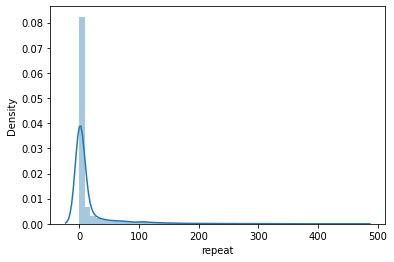

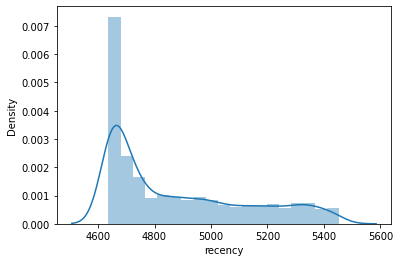

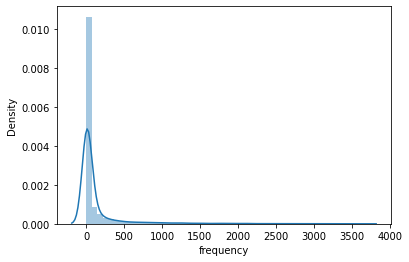

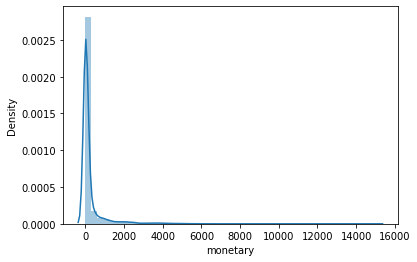

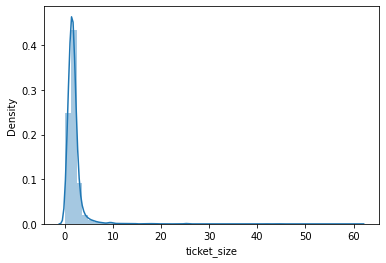

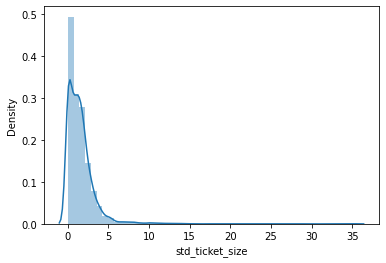

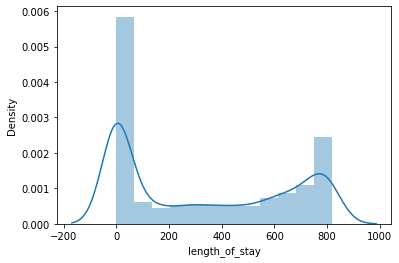

In [71]:
for i, col in enumerate(df_sgv2.columns[1:]):
    plt.figure(i)
    sns.distplot(df_sgv2[col])
    
plt.show()

# **Standardized Scales**

In [95]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df_sgv2.iloc[:,1:]))

In [96]:
wcss = []
silet = []
num_k = []
i=1
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k) 
    kmeans = kmeans.fit(df_std)
    num_k.append(k)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    silet.append(silhouette_score(df_std,kmeans.labels_,metric='euclidean'))
    i=i+1

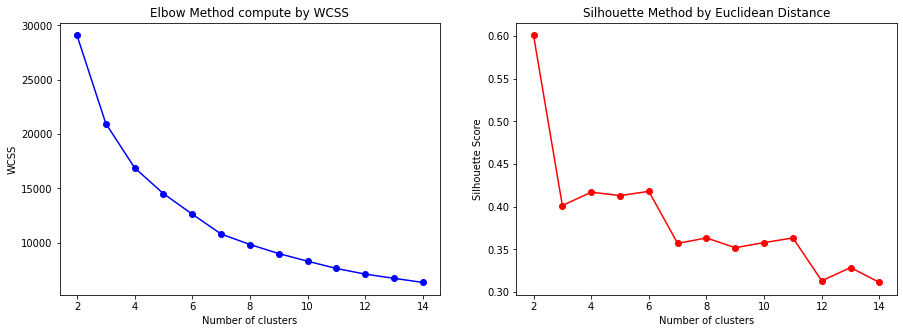

In [103]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(num_k, wcss, 'bo-')
axes[0].set_title('Elbow Method compute by WCSS')
axes[0].set_xlabel("Number of clusters")
axes[0].set_ylabel("WCSS")

axes[1].plot(num_k, silet, 'bo-' ,color = 'red')
axes[1].set_title('Silhouette Method by Euclidean Distance')
axes[1].set_xlabel("Number of clusters")
axes[1].set_ylabel("Silhouette Score")

plt.show()

In [105]:
df_sgv2 = df_sgv2.reset_index()

In [106]:
cluster = KMeans(n_clusters=6)
df_sgv2['cluster'] = cluster.fit_predict(df_std)

In [108]:
df_sgv2.head()

,CUST_CODE,reactivated,repeat,recency,frequency,monetary,ticket_size,std_ticket_size,length_of_stay,cluster
0,CUST0000000181,0,0,5184,1,2.44,2.440000,0.000000,0,0
1,CUST0000000369,0,191,4638,699,959.33,1.372432,1.790510,811,3
2,CUST0000000689,1,14,4650,185,328.57,1.776054,1.797741,337,1
3,CUST0000000998,0,2,5367,4,5.95,1.487500,0.695000,64,0
4,CUST0000001163,1,2,4651,25,39.74,1.589600,1.870184,609,1


<Figure size 2160x720 with 0 Axes>

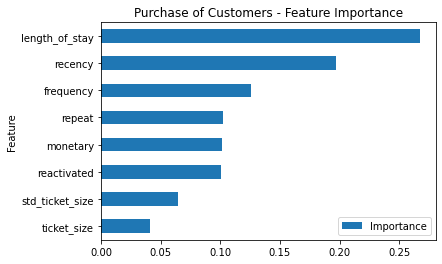

In [113]:
X=df_sgv2.iloc[:,1:-1]
y=df_sgv2.iloc[:,-1]
clf=RandomForestClassifier(criterion='entropy').fit(X,y)
plt.figure(figsize=(30,10))
df_sgv2_importance = pd.DataFrame({'Feature':X.columns,'Importance':clf.feature_importances_}).set_index('Feature')
df_sgv2_importance.sort_values('Importance').plot.barh(title='Purchase of Customers - Feature Importance')

In [107]:
dfCluster = df_sgv2.groupby('cluster', as_index=False).mean()
dfCluster['NO_CUST'] = df_sgv2[['cluster','CUST_CODE']].groupby('cluster').count()

dfCluster

,cluster,reactivated,repeat,recency,frequency,monetary,ticket_size,std_ticket_size,length_of_stay,NO_CUST
0,0,0.153714,0.502225,5077.417323,7.749059,13.725231,1.642196,0.905440,40.736049,2921
1,1,1.562677,10.954564,4698.999594,74.676268,139.461156,1.771551,1.687543,572.851521,2465
2,2,0.037313,210.425373,4640.873134,2021.880597,3855.487463,1.927381,2.561817,808.768657,134
3,3,0.183908,102.632184,4645.041379,739.675862,1341.149540,1.851654,2.201586,774.020690,435
4,4,0.818182,4.734848,4895.037879,26.265152,122.519545,7.116034,10.292317,295.310606,132
5,5,0.230769,0.000000,5049.384615,1.692308,58.660769,33.845385,2.801062,125.769231,13


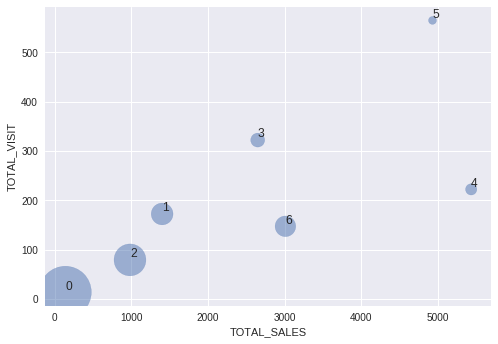

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_SALES'], dfCluster['TOTAL_VISIT'], s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_SALES")
ax.set_ylabel("TOTAL_VISIT")

for i, txt in enumerate(dfCluster['cluster']):
  ax.annotate(txt, (dfCluster['TOTAL_SALES'][i], dfCluster["TOTAL_VISIT"][i]), horizontalalignment='middle', verticalalignment='middle')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


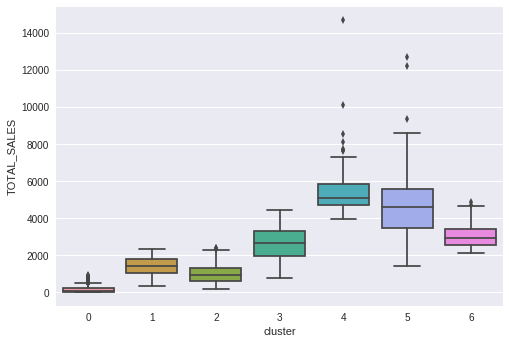

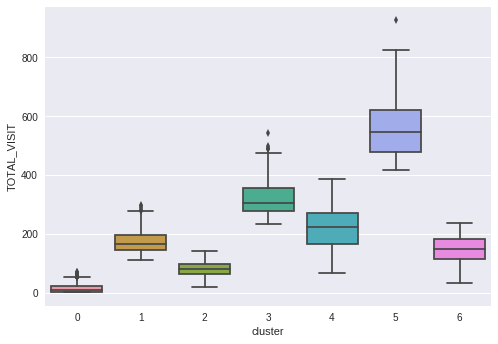

In [ ]:
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(x="cluster", y =col, data=df)
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

predictors = df.iloc[:,1:-1]
targets = df.iloc[:,-1:]

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(predictors_scaled, targets.values.ravel())


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
importances = list(classifier.feature_importances_)

feature_list = list(predictors.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TOTAL_SALES          Importance: 0.55
Variable: TOTAL_VISIT          Importance: 0.45
